# PySAL *segregation* module: dotmaps

Exploring the use of dotmaps to visualize segregation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import geopandas as gpd
import segregation
import libpysal
import pointpats
import numpy as np

/home/serge/Dropbox/p/pysal/src/subpackages/segregation/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


In [2]:
from geopandas import GeoSeries
from shapely.geometry import Point

Then it's time to load some data to estimate segregation. We use the data of 2000 Census Tract Data for the metropolitan area of Sacramento, CA, USA. 

We use a geopandas dataframe available in PySAL examples repository. We highlight that for nonspatial segregation measures only a pandas dataframe would also work to estimate.

For more information about the data: https://github.com/pysal/libpysal/tree/master/libpysal/examples/sacramento2

In [3]:
s_map = gpd.read_file(libpysal.examples.get_path("sacramentot2.shp"))
s_map.columns

Index(['FIPS', 'MSA', 'TOT_POP', 'POP_16', 'POP_65', 'WHITE_', 'BLACK_',
       'ASIAN_', 'HISP_', 'MULTI_RA', 'MALES', 'FEMALES', 'MALE1664',
       'FEM1664', 'EMPL16', 'EMP_AWAY', 'EMP_HOME', 'EMP_29', 'EMP_30',
       'EMP16_2', 'EMP_MALE', 'EMP_FEM', 'OCC_MAN', 'OCC_OFF1', 'OCC_INFO',
       'HH_INC', 'POV_POP', 'POV_TOT', 'HSG_VAL', 'FIPSNO', 'POLYID',
       'geometry'],
      dtype='object')

The data have several demographic variables. We are going to assess the segregation of the Hispanic Population (variable 'HISP_'). For this, we only extract some columns of the geopandas dataframe.

In [4]:
gdf = s_map[['geometry', 'HISP_', 'TOT_POP', 'ASIAN_', "BLACK_", 'WHITE_']]

We also can plot the spatial distribution of the composition of the Hispanic population over the tracts of Sacramento:

/home/serge/anaconda3/envs/pysaldev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


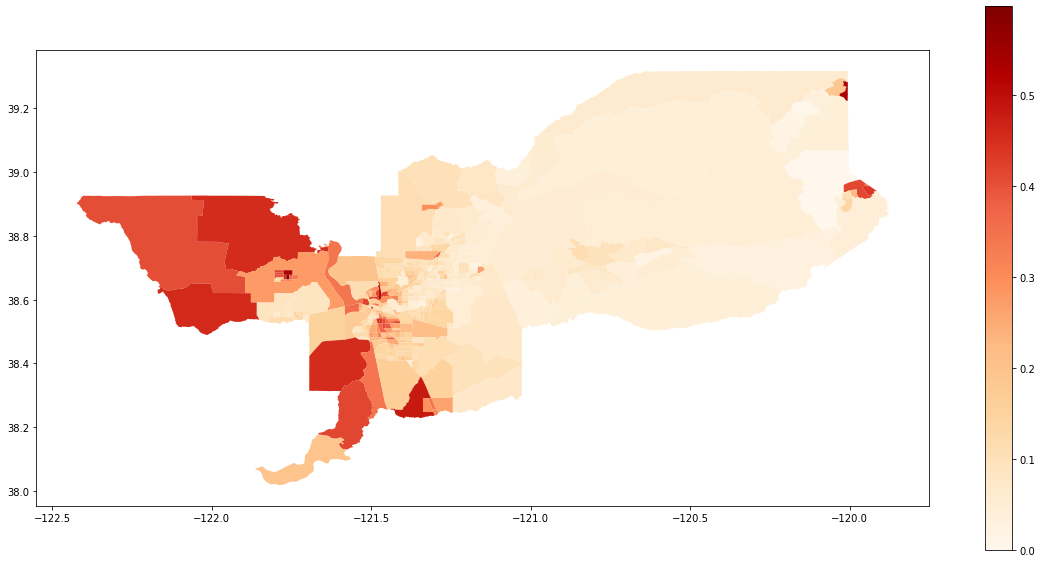

In [5]:
gdf['composition'] = gdf['HISP_'] / gdf['TOT_POP']

gdf.plot(column = 'composition',
         cmap = 'OrRd', 
         figsize=(20,10),
         legend = True)

In [6]:
units = gdf.geometry

In [7]:
u0 = units[0]

In [8]:
from pointpats import Window, PoissonPointProcess

In [9]:
window = Window(libpysal.cg.asShape(u0).parts)

In [10]:
samples1 = PoissonPointProcess(window, 10, 2, conditioning=False, asPP=False)


In [11]:
samples1.realizations[1]

array([[-120.20757997,   39.28208887],
       [-120.69105092,   39.27795613],
       [-120.51054774,   39.25478895],
       [-120.86978056,   39.1628653 ],
       [-120.25305176,   39.31107742],
       [-120.58124295,   39.26618177],
       [-120.38460409,   39.29963547],
       [-120.1964682 ,   39.18637571],
       [-120.16315212,   39.29765689],
       [-120.27233924,   39.27499017]])

In [12]:
def points_in_row(row, groups=['HISP_', 'BLACK_' ,'ASIAN_']):
    window = Window(libpysal.cg.asShape(row.geometry).parts)
    counts = row[groups]
    points = []
    #print(counts)
    for count in counts:
        if count > 0:
            pnts = PoissonPointProcess(window, count, 1, conditioning=False, 
                                       asPP=False).realizations[0]
        else:
            pnts = np.array([[-999, -999]])
        points.append(pnts)
    return counts, points

In [13]:
h = []
b = []
a = []
for i, row in gdf.iterrows():
    #print(i)
    counts, points = points_in_row(row)
    hi, bi, ai = points
    h.append(hi)
    b.append(bi)
    a.append(ai)

In [14]:
def filter_zero(group):
    group = np.vstack(group)
    return group[np.where(group != -999)].reshape(-1,2)

In [15]:
ba = filter_zero(b)
ha = filter_zero(h)
aa = filter_zero(a)

In [16]:
h_gdf = gpd.GeoDataFrame(geometry = GeoSeries(map(Point, zip(ha[:,0], ha[:,1]))))
b_gdf = gpd.GeoDataFrame(geometry = GeoSeries(map(Point, zip(ba[:,0], ba[:,1]))))
a_gdf = gpd.GeoDataFrame(geometry = GeoSeries(map(Point, zip(aa[:,0], aa[:,1]))))

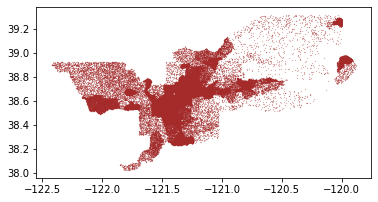

In [17]:
h_gdf.plot(markersize=0.02, color='brown')

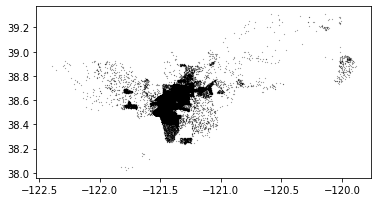

In [18]:
b_gdf.plot(markersize=0.02, color='black')

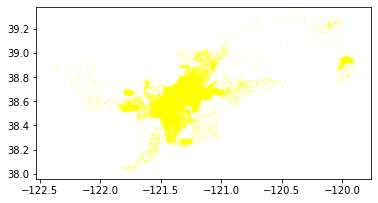

In [19]:
a_gdf.plot(markersize=0.02, color='yellow')

(-122.549289, -119.75000899999999, 37.9535193, 39.3813787)

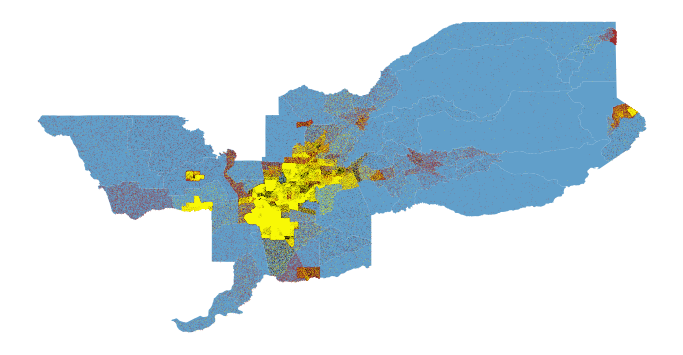

In [20]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
h_gdf.plot(markersize=0.002, color='brown', ax=ax)
b_gdf.plot(markersize=0.002, color='black', ax=ax)
a_gdf.plot(markersize=0.002, color='yellow', ax=ax)

ax.axis('off')

(-122.549289, -119.75000899999999, 37.9535193, 39.3813787)

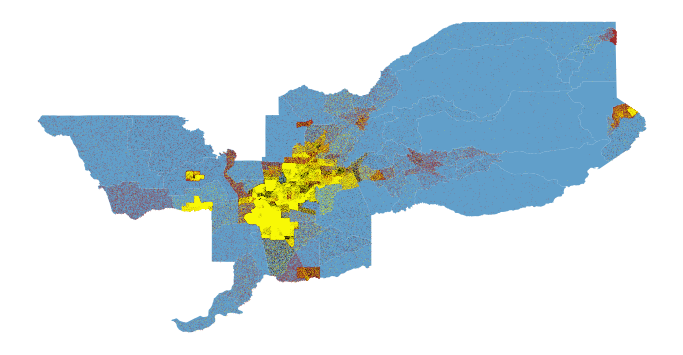

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
h_gdf.plot(markersize=0.002, color='brown', ax=ax)
b_gdf.plot(markersize=0.002, color='black', ax=ax)
a_gdf.plot(markersize=0.002, color='yellow', ax=ax)

ax.axis('off')

(-122.0, -121.0, 38.0, 38.8)

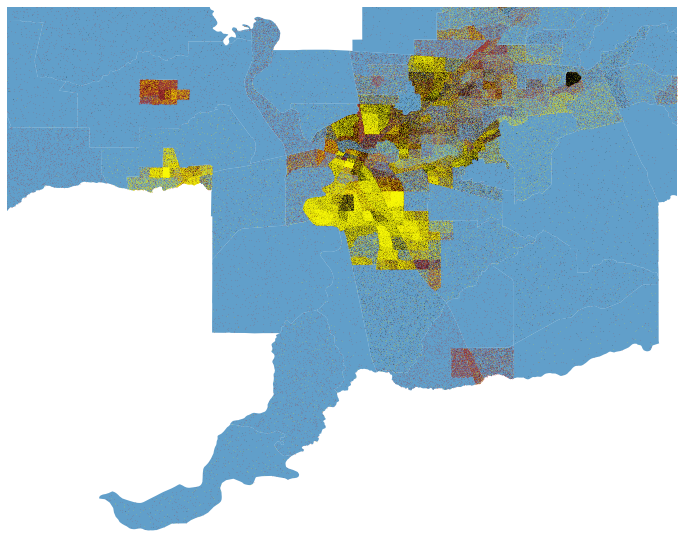

In [22]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
h_gdf.plot(markersize=0.002, color='brown', ax=ax)
b_gdf.plot(markersize=0.002, color='black', ax=ax)
a_gdf.plot(markersize=0.002, color='yellow', ax=ax)
ax.axis((-122.0,-121.0,38.0,38.8))

ax.axis('off')

(-122.0, -121.0, 38.0, 38.8)

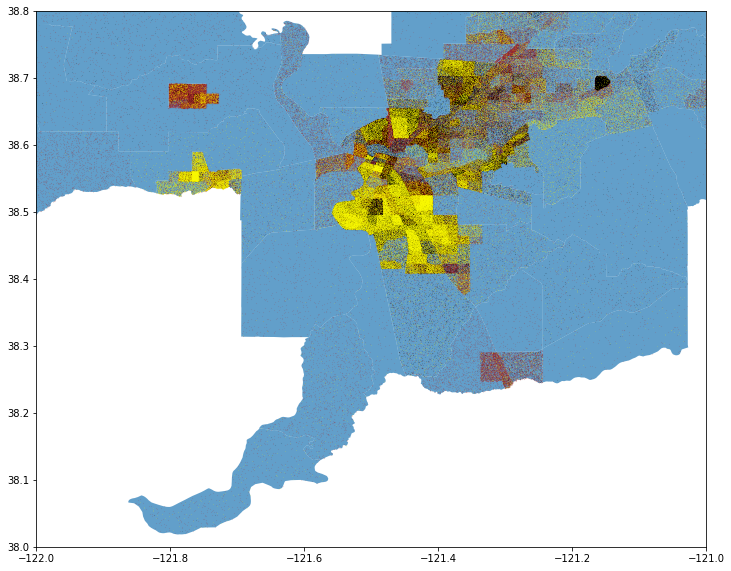

In [23]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
h_gdf.plot(markersize=0.002, color='brown', ax=ax)
b_gdf.plot(markersize=0.002, color='black', ax=ax)
a_gdf.plot(markersize=0.002, color='yellow', ax=ax)
ax.axis((-122.0,-121.0,38.0,38.8))

#ax.axis('off')

(-122.0, -121.0, 38.0, 38.8)

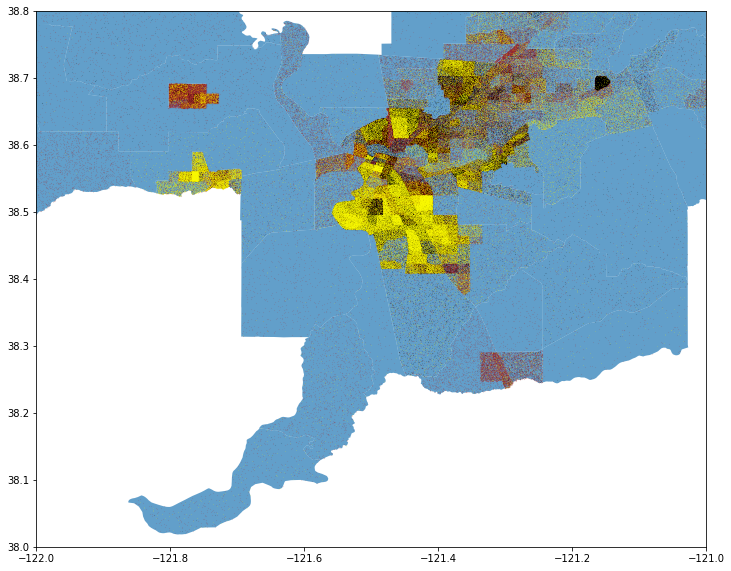

In [24]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
h_gdf.plot(markersize=0.002, color='brown', ax=ax)
b_gdf.plot(markersize=0.002, color='black', ax=ax)
a_gdf.plot(markersize=0.002, color='yellow', ax=ax)
ax.axis((-122.0,-121.0,38.0,38.8))

#ax.axis('off')

(-122.0, -121.0, 38.0, 38.8)

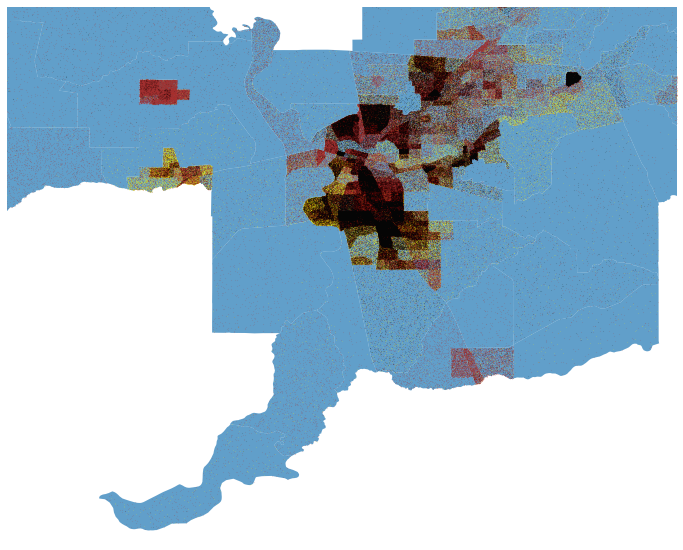

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
a_gdf.plot(markersize=0.002, color='yellow', ax=ax)
h_gdf.plot(markersize=0.002, color='brown', ax=ax)

b_gdf.plot(markersize=0.002, color='black', ax=ax)
ax.axis((-122.0,-121.0,38.0,38.8))


ax.axis('off')

(-121.6, -121.0, 38.4, 38.8)

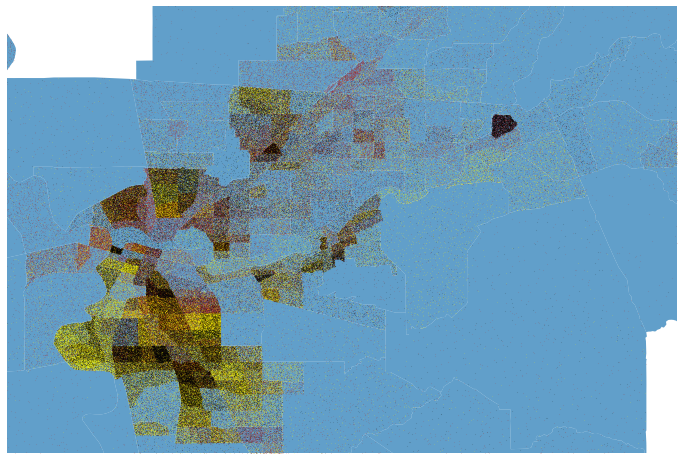

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
h_gdf.plot(markersize=0.002, color='brown', ax=ax)

a_gdf.plot(markersize=0.002, color='yellow', ax=ax)

b_gdf.plot(markersize=0.002, color='black', ax=ax)
ax.axis((-121.6,-121.0,38.4,38.8))


ax.axis('off')

## 1-dot = 10 individuals
This is not technically correct, but an approximation as we are sampling over the complete set of points rather than by individual enumeration unit. For now, just exploring effect of thinning.

In [27]:
n_a, _ = a_gdf.shape
n_b, _ = b_gdf.shape
n_h, _ = h_gdf.shape

In [28]:
n_a, n_b, n_h

(158820, 122022, 277574)

In [29]:
aid = list(range(0, n_a, 10))

In [30]:
a_gdf10 = a_gdf.iloc[aid]
h_gdf10 = h_gdf.iloc[list(range(0, n_h, 10))]
b_gdf10 = b_gdf.iloc[list(range(0, n_b, 10))]

(-122.549289, -119.75000899999999, 37.9535193, 39.3813787)

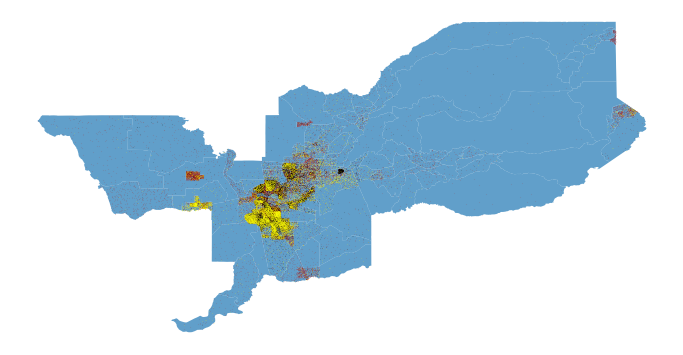

In [31]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
h_gdf10.plot(markersize=0.002, color='brown', ax=ax)
b_gdf10.plot(markersize=0.002, color='black', ax=ax)
a_gdf10.plot(markersize=0.002, color='yellow', ax=ax)

ax.axis('off')

(-121.6, -121.0, 38.4, 38.8)

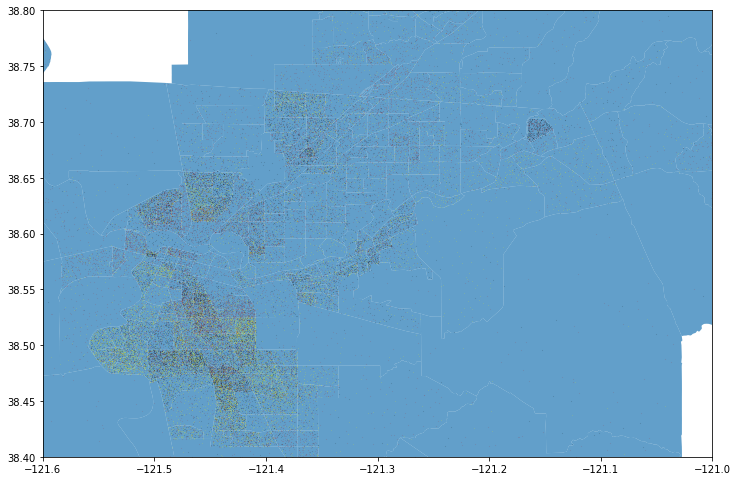

In [32]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
h_gdf10.plot(markersize=0.002, color='brown', ax=ax)
b_gdf10.plot(markersize=0.002, color='black', ax=ax)
a_gdf10.plot(markersize=0.002, color='yellow', ax=ax)
ax.axis((-121.6,-121.0,38.4,38.8))

#ax.axis('off')

In [33]:
xlim=(-122, -121)
ylim=(38.5, 38.8)

(-122.0, -121.0, 38.0, 38.8)

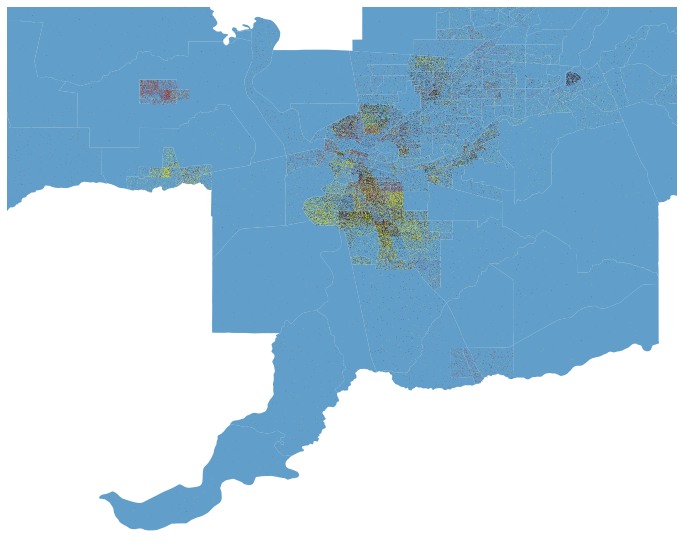

In [34]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf.plot(ax=ax,alpha=0.7)
h_gdf10.plot(markersize=0.002, color='brown', ax=ax)
b_gdf10.plot(markersize=0.002, color='black', ax=ax)
a_gdf10.plot(markersize=0.002, color='yellow', ax=ax)
ax.axis((-122.0,-121.0,38.0,38.8))
ax.axis('off')